## **MLP 하이퍼파라미터 튜닝 실험** 🔍

- 다층 퍼셉트론 모델에서 주요 하이퍼파라미터 조정에 따른 성능 변화를 분석하는 실험입니다.
- 본 문서는 해당 실험의 설계, 과정 및 결과를 기술합니다.

> **평가 지표:** 테스트 정확도, 테스트 손실, 총 훈련 시간

<br>

**실험**
1. 베이스라인 구현
2. 네트워크 구조 (깊이)
3. 네트워크 구조 (너비)
4. 활성화 함수
5. 옵티마이저
6. 학습률

<br>

**사용할 데이터셋**

- **MNIST**: 0부터 9까지의 손글씨 숫자 이미지로 구성된 표준 데이터셋
- **구성**: 60,000개의 학습 데이터와 10,000개의 테스트 데이터
- **형식**: 각 이미지는 28×28 픽셀의 그레이스케일 형식

<br>

**사용한 환경**

- **하드웨어**: MacBook Air M2 (CPU)
- **소프트웨어**: Visual Studio Code + Jupyter Notebook
- **Python**: .venv (3.9.6)
- **주요 라이브러리**: PyTorch, NumPy, Matplotlib
- **개발 환경 선택 이유**: Google Colab보다 로컬 개발 환경이 실행 속도가 더 빠름

<br>

---

**작성자**: 2271064 한사랑

## **Import Libraries**

구현에 필요한 핵심 라이브러리를 가져오는 단계

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install torch torchvision

In [1]:
# 데이터 처리 및 수학 연산을 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms  # transforms 추가
from torchvision.transforms import ToTensor

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## **Load and Preprocess Data**
MNIST 데이터셋을 로드하고 전처리하는 단계

- **데이터 로드**: PyTorch의 datasets.MNIST 클래스를 사용하여 손글씨 숫자 이미지 데이터를 다운로드.

- **데이터 분할**: 원본 학습 데이터셋을 8:2 비율로 학습셋과 검증셋으로 나눔.

- **데이터셋 확인**: 각 데이터셋의 크기를 출력하여 확인.

### 데이터셋 로드 및 전처리

In [2]:
# -- 제공된 코드 --

# Define transformations: convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

### 데이터셋 분할 및 시각화

학습 데이터셋 크기: 48000
검증 데이터셋 크기: 12000
테스트 데이터셋 크기: 10000


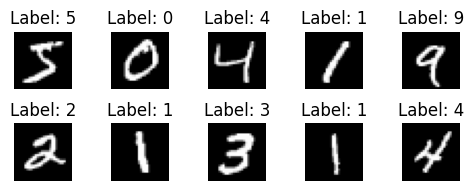

In [3]:
# 학습 데이터셋을 학습/검증 세트로 분할 (8:2 비율)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# DataLoader 생성
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 데이터셋 크기 확인
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"테스트 데이터셋 크기: {len(testset)}")

# MNIST 데이터 시각화
plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img, label = trainset[i]
    img = img.squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## **실험 1: 베이스라인 모델 (Baseline Model)**

**모델 아키텍처**는 다음과 같습니다.

- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, Sigmoid 활성화 함수
- **은닉층 2**: 32 unit, Sigmoid 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 베이스라인 모델 클래스 정의

In [4]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super(BaselineMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # 시그모이드 활성화 함수
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.sigmoid(self.fc1(x))  # 첫 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc2(x))  # 두 번째 은닉층 + 활성화 함수
        x = self.fc3(x)                # 출력층
        
        return x
    
# 모델 인스턴스 생성
model = BaselineMLP().to(device)
print(model)

BaselineMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 손실 함수 및 옵티마이저 정의

In [5]:
# 손실 함수 정의 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 학습률=0.1)
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### 학습 함수 정의

In [6]:
import time
from datetime import timedelta

# 학습 및 검증 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    # 결과 저장용 리스트
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # 전체 학습 시간 측정 시작
    total_start_time = time.time()
    
    print("학습 시작...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 학습 단계
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 학습 평균 손실 및 정확도 계산
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * (correct / total)
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # 검증 모드
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 단계
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # 검증 평균 손실 및 정확도 계산
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * (correct / total)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # 결과 출력
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%")
        print(f"Valid - Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%")
        print("-" * 50)
    
    # 총 학습 시간 계산 및 출력
    total_time = time.time() - total_start_time
    print(f"총 학습 시간: {str(timedelta(seconds=total_time))}")
    
    return model, train_losses, train_accs, val_losses, val_accs, total_time

### 평가 함수 정의

In [7]:
# 테스트 함수 정의
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * (correct / total)
    
    print("-" * 50)
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"테스트 정확도: {test_acc:.2f}%")
    
    return test_loss, test_acc

### 모델 학습 실행

In [8]:
# 모델 학습 및 평가 실행
num_epochs = 10
model, train_losses, train_accs, val_losses, val_accs, total_time = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
test_loss, test_acc = test_model(model, test_loader, criterion, device)

# 실험 결과 저장
baseline_results = {
    'model': 'Baseline MLP',
    'hidden_layers': '2 layers, 32 units each',
    'activation': 'Sigmoid',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'training_time': total_time
}

print("-" * 50)
print("베이스라인 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 1.6592, Accuracy: 49.39%
Valid - Loss: 0.8937, Accuracy: 75.77%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 0.6089, Accuracy: 84.81%
Valid - Loss: 0.4415, Accuracy: 88.71%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 0.3706, Accuracy: 90.61%
Valid - Loss: 0.3308, Accuracy: 91.02%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 0.2909, Accuracy: 92.38%
Valid - Loss: 0.2792, Accuracy: 92.41%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 0.2448, Accuracy: 93.63%
Valid - Loss: 0.2471, Accuracy: 93.08%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 0.2139, Accuracy: 94.40%
Valid - Loss: 0.2234, Accuracy: 93.72%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 0.1908, Accuracy: 94.94%
Valid - Loss: 0.2043, Accuracy: 94.4

### 베이스라인 모델 성능 시각화

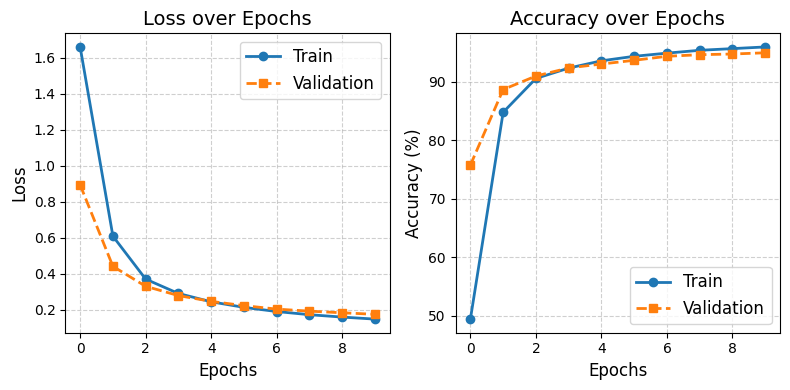

Test Accuracy: 95.39%
Test Loss: 0.1662
Training Time: 0:00:28.059741


,Model,Hidden Layers,Activation,Optimizer,Learning Rate,Test Accuracy (%),Training Time (s)
0,Baseline MLP,"2 layers, 32 units each",Sigmoid,SGD,0.1,95.39,28.06


In [9]:
# 학습 결과 시각화 함수
def visualize_training_results(results):
    plt.figure(figsize=(8, 4))
    
    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train', marker='o', markersize=6, linestyle='-', linewidth=2)
    plt.plot(results['val_losses'], label='Validation', marker='s', markersize=6, linestyle='--', linewidth=2)
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accs'], label='Train', marker='o', markersize=6, linestyle='-', linewidth=2)
    plt.plot(results['val_accs'], label='Validation', marker='s', markersize=6, linestyle='--', linewidth=2)
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # 테스트 결과 출력
    print(f"Test Accuracy: {results['test_acc']:.2f}%")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Training Time: {timedelta(seconds=results['training_time'])}")

# 베이스라인 모델 학습 결과 시각화
visualize_training_results(baseline_results)

# 성능 요약 표시
performance_summary = {
    'Model': [baseline_results['model']],
    'Hidden Layers': [baseline_results['hidden_layers']],
    'Activation': [baseline_results['activation']],
    'Optimizer': [baseline_results['optimizer']],
    'Learning Rate': [baseline_results['learning_rate']],
    'Test Accuracy (%)': [f"{baseline_results['test_acc']:.2f}"],
    'Training Time (s)': [f"{baseline_results['training_time']:.2f}"]
}

# 결과 표 생성
import pandas as pd
summary_df = pd.DataFrame(performance_summary)
display(summary_df)

## **실험 2: 더 깊은 네트워크 모델 (Deeper Model)**

**모델 아키텍처**는 다음과 같습니다.

- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, Sigmoid 활성화 함수
- **은닉층 2**: 32 unit, Sigmoid 활성화 함수
- **은닉층 3**: 32 unit, Sigmoid 활성화 함수
- **은닉층 4**: 32 unit, Sigmoid 활성화 함수
- **은닉층 5**: 32 unit, Sigmoid 활성화 함수
- **은닉층 6**: 32 unit, Sigmoid 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 더 깊은 네트워크 모델 정의

In [10]:
class DeeperMLP(nn.Module):
    def __init__(self):
        super(DeeperMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 6개 은닉층(각 32 유닛) -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 32)     # 두 번째 은닉층 -> 세 번째 은닉층
        self.fc4 = nn.Linear(32, 32)     # 세 번째 은닉층 -> 네 번째 은닉층
        self.fc5 = nn.Linear(32, 32)     # 네 번째 은닉층 -> 다섯 번째 은닉층
        self.fc6 = nn.Linear(32, 32)     # 다섯 번째 은닉층 -> 여섯 번째 은닉층
        self.fc7 = nn.Linear(32, 10)     # 여섯 번째 은닉층 -> 출력층
        
        # 시그모이드 활성화 함수
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.sigmoid(self.fc1(x))  # 첫 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc2(x))  # 두 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc3(x))  # 세 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc4(x))  # 네 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc5(x))  # 다섯 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc6(x))  # 여섯 번째 은닉층 + 활성화 함수
        x = self.fc7(x)                # 출력층
        
        return x

# 모델 인스턴스 생성 및 출력
deeper_model = DeeperMLP().to(device)
print(deeper_model)

DeeperMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 더 깊은 네트워크 모델 학습

In [11]:
# 손실 함수 정의 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 기본 학습률 유지)
deeper_optimizer = optim.SGD(deeper_model.parameters(), lr=learning_rate)

# 모델 학습 및 평가 실행
num_epochs = 10
deeper_model, deeper_train_losses, deeper_train_accs, deeper_val_losses, deeper_val_accs, deeper_total_time = train_model(
    deeper_model, train_loader, val_loader, criterion, deeper_optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
deeper_test_loss, deeper_test_acc = test_model(deeper_model, test_loader, criterion, device)

# 실험 결과 저장
deeper_results = {
    'model': 'Deeper MLP',
    'hidden_layers': '6 layers, 32 units each',
    'activation': 'Sigmoid',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': deeper_train_losses,
    'train_accs': deeper_train_accs,
    'val_losses': deeper_val_losses,
    'val_accs': deeper_val_accs,
    'test_loss': deeper_test_loss,
    'test_acc': deeper_test_acc,
    'training_time': deeper_total_time
}

print("-" * 50)
print("더 깊은 네트워크 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 2.3051, Accuracy: 10.64%
Valid - Loss: 2.3048, Accuracy: 9.73%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 2.3042, Accuracy: 10.62%
Valid - Loss: 2.3037, Accuracy: 11.15%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 2.3040, Accuracy: 10.73%
Valid - Loss: 2.3059, Accuracy: 9.79%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 2.3040, Accuracy: 10.68%
Valid - Loss: 2.3072, Accuracy: 11.15%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 2.3036, Accuracy: 10.78%
Valid - Loss: 2.3042, Accuracy: 11.15%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 2.3038, Accuracy: 10.71%
Valid - Loss: 2.3023, Accuracy: 11.15%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 2.3035, Accuracy: 10.48%
Valid - Loss: 2.3028, Accuracy: 11.15%

### 모델 학습 결과 시각화 및 비교

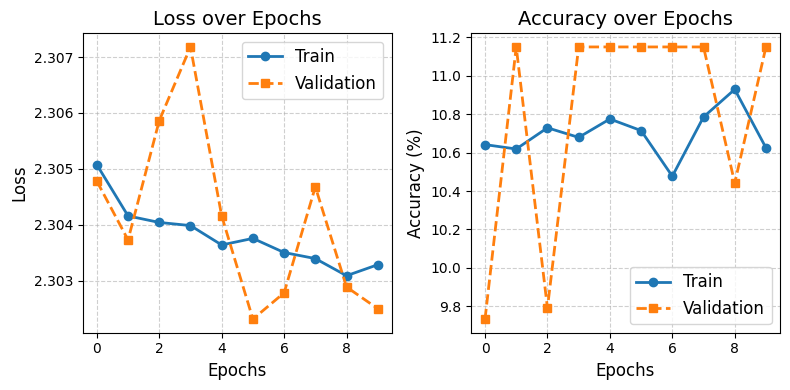

Test Accuracy: 11.35%
Test Loss: 2.3019
Training Time: 0:00:29.461635


,Model,Hidden Layers,Activation,Test Accuracy (%),Test Loss,Training Time (s)
0,Baseline MLP,"2 layers, 32 units each",Sigmoid,95.39,0.1662,28.06
1,Deeper MLP,"6 layers, 32 units each",Sigmoid,11.35,2.3019,29.46


In [12]:
# 더 깊은 모델 학습 결과 시각화
visualize_training_results(deeper_results)

# 성능 요약 표시 (베이스라인 모델과 비교)
performance_summary = {
    'Model': [baseline_results['model'], deeper_results['model']],
    'Hidden Layers': [baseline_results['hidden_layers'], deeper_results['hidden_layers']],
    'Activation': [baseline_results['activation'], deeper_results['activation']],
    'Test Accuracy (%)': [f"{baseline_results['test_acc']:.2f}", f"{deeper_results['test_acc']:.2f}"],
    'Test Loss': [f"{baseline_results['test_loss']:.4f}", f"{deeper_results['test_loss']:.4f}"],
    'Training Time (s)': [f"{baseline_results['training_time']:.2f}", f"{deeper_results['training_time']:.2f}"]
}

# 결과 표 생성
summary_df = pd.DataFrame(performance_summary)
display(summary_df)

## **실험 3: 더 넓은 네트워크 모델 (Wider Model)**

**모델 아키텍처**는 다음과 같습니다.

- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 512 unit, Sigmoid 활성화 함수
- **은닉층 2**: 512 unit, Sigmoid 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 더 넓은 네트워크 모델 정의

In [13]:
class WiderMLP(nn.Module):
    def __init__(self):
        super(WiderMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 512 -> 은닉층 512 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 512)  # 입력층 -> 첫 번째 은닉층 (더 넓게: 512 유닛)
        self.fc2 = nn.Linear(512, 512)    # 첫 번째 은닉층 -> 두 번째 은닉층 (더 넓게: 512 유닛)
        self.fc3 = nn.Linear(512, 10)     # 두 번째 은닉층 -> 출력층
        
        # 시그모이드 활성화 함수 (베이스라인과 동일)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.sigmoid(self.fc1(x))  # 첫 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc2(x))  # 두 번째 은닉층 + 활성화 함수
        x = self.fc3(x)                # 출력층
        
        return x

# 모델 인스턴스 생성 및 출력
wider_model = WiderMLP().to(device)
print(wider_model)

WiderMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 더 넓은 모델 학습

In [14]:
# 손실 함수 정의 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 기본 학습률 유지)
wider_optimizer = optim.SGD(wider_model.parameters(), lr=learning_rate)

# 모델 학습 및 평가 실행
num_epochs = 10
wider_model, wider_train_losses, wider_train_accs, wider_val_losses, wider_val_accs, wider_total_time = train_model(
    wider_model, train_loader, val_loader, criterion, wider_optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
wider_test_loss, wider_test_acc = test_model(wider_model, test_loader, criterion, device)

# 실험 결과 저장
wider_results = {
    'model': 'Wider MLP',
    'hidden_layers': '2 layers, 512 units each',
    'activation': 'Sigmoid',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': wider_train_losses,
    'train_accs': wider_train_accs,
    'val_losses': wider_val_losses,
    'val_accs': wider_val_accs,
    'test_loss': wider_test_loss,
    'test_acc': wider_test_acc,
    'training_time': wider_total_time
}

print("-" * 50)
print("더 넓은 네트워크 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 1.0966, Accuracy: 63.84%
Valid - Loss: 0.4222, Accuracy: 88.05%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 0.3669, Accuracy: 89.34%
Valid - Loss: 0.3293, Accuracy: 90.34%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 0.2989, Accuracy: 91.29%
Valid - Loss: 0.2811, Accuracy: 91.84%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 0.2561, Accuracy: 92.47%
Valid - Loss: 0.2533, Accuracy: 92.44%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 0.2237, Accuracy: 93.45%
Valid - Loss: 0.2202, Accuracy: 93.66%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 0.1950, Accuracy: 94.30%
Valid - Loss: 0.2129, Accuracy: 93.47%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 0.1723, Accuracy: 95.00%
Valid - Loss: 0.1861, Accuracy: 94.4

### 모델 학습 결과 시각화 및 비교

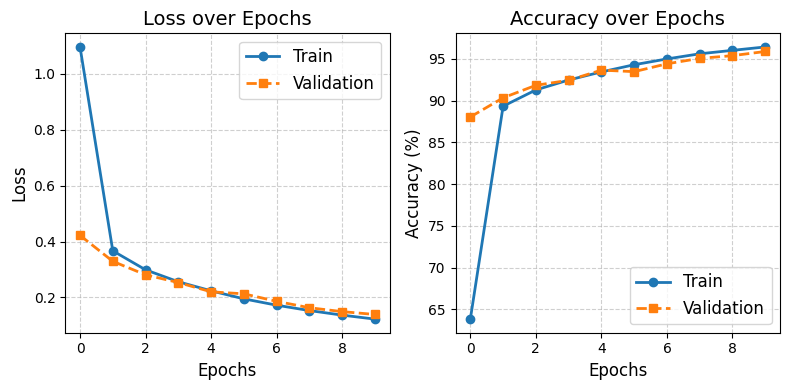

Test Accuracy: 96.15%
Test Loss: 0.1289
Training Time: 0:00:32.973260


,Model,Hidden Layers,Activation,Test Accuracy (%),Test Loss,Training Time (s)
0,Baseline MLP,"2 layers, 32 units each",Sigmoid,95.39,0.1662,28.06
1,Deeper MLP,"6 layers, 32 units each",Sigmoid,11.35,2.3019,29.46
2,Wider MLP,"2 layers, 512 units each",Sigmoid,96.15,0.1289,32.97


In [15]:
# 더 넓은 모델 학습 결과 시각화
visualize_training_results(wider_results)

# 성능 요약 표시 (베이스라인, 깊은 모델, 넓은 모델 비교)
performance_summary = {
    'Model': [baseline_results['model'], deeper_results['model'], wider_results['model']],
    'Hidden Layers': [baseline_results['hidden_layers'], deeper_results['hidden_layers'], wider_results['hidden_layers']],
    'Activation': [baseline_results['activation'], deeper_results['activation'], wider_results['activation']],
    'Test Accuracy (%)': [f"{baseline_results['test_acc']:.2f}", f"{deeper_results['test_acc']:.2f}", f"{wider_results['test_acc']:.2f}"],
    'Test Loss': [f"{baseline_results['test_loss']:.4f}", f"{deeper_results['test_loss']:.4f}", f"{wider_results['test_loss']:.4f}"],
    'Training Time (s)': [f"{baseline_results['training_time']:.2f}", f"{deeper_results['training_time']:.2f}", f"{wider_results['training_time']:.2f}"]
}

# 결과 표 생성
summary_df = pd.DataFrame(performance_summary)
display(summary_df)

## **실험 4: 활성화 함수 수정 모델 (Activation Function Variation)**

**모델 아키텍처**는 다음과 같습니다.

**1) Tanh 함수 사용:**
- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, Tanh 활성화 함수
- **은닉층 2**: 32 unit, Tanh 활성화 함수
- **출력층**: 10 unit (0-9 class)

**2) ReLU 함수 사용:**
- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, ReLU 활성화 함수
- **은닉층 2**: 32 unit, ReLU 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 다양한 활성화 함수 모델 정의

In [16]:
# 1. Tanh 활성화 함수를 사용하는 모델 정의
class TanhMLP(nn.Module):
    def __init__(self):
        super(TanhMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # Tanh 활성화 함수
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.tanh(self.fc1(x))  # 첫 번째 은닉층 + Tanh 활성화 함수
        x = self.tanh(self.fc2(x))  # 두 번째 은닉층 + Tanh 활성화 함수
        x = self.fc3(x)             # 출력층
        
        return x

# 2. ReLU 활성화 함수를 사용하는 모델 정의
class ReLUMLP(nn.Module):
    def __init__(self):
        super(ReLUMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # ReLU 활성화 함수
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.relu(self.fc1(x))  # 첫 번째 은닉층 + ReLU 활성화 함수
        x = self.relu(self.fc2(x))  # 두 번째 은닉층 + ReLU 활성화 함수
        x = self.fc3(x)             # 출력층
        
        return x

# 모델 인스턴스 생성
tanh_model = TanhMLP().to(device)
relu_model = ReLUMLP().to(device)

# 모델 구조 출력
print("===== Tanh 활성화 함수 모델 =====")
print(tanh_model)
print("\n===== ReLU 활성화 함수 모델 =====")
print(relu_model)

===== Tanh 활성화 함수 모델 =====
TanhMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (tanh): Tanh()
)

===== ReLU 활성화 함수 모델 =====
ReLUMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)


### 다양한 활성화 함수 모델 학습

In [17]:
# ----- Tanh 모델 학습 및 평가 -----
# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 베이스라인과 동일한 학습률 유지)
tanh_optimizer = optim.SGD(tanh_model.parameters(), lr=learning_rate)

# 모델 학습 실행
num_epochs = 10
tanh_model, tanh_train_losses, tanh_train_accs, tanh_val_losses, tanh_val_accs, tanh_total_time = train_model(
    tanh_model, train_loader, val_loader, criterion, tanh_optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
tanh_test_loss, tanh_test_acc = test_model(tanh_model, test_loader, criterion, device)

# 실험 결과 저장
tanh_results = {
    'model': 'Tanh MLP',
    'hidden_layers': '2 layers, 32 units each',
    'activation': 'Tanh',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': tanh_train_losses,
    'train_accs': tanh_train_accs,
    'val_losses': tanh_val_losses,
    'val_accs': tanh_val_accs,
    'test_loss': tanh_test_loss,
    'test_acc': tanh_test_acc,
    'training_time': tanh_total_time
}

print("-" * 50)
print("Tanh 활성화 함수 모델 학습 완료!")

# ----- ReLU 모델 학습 및 평가 -----
# 옵티마이저 정의 (SGD, 베이스라인과 동일한 학습률 유지)
relu_optimizer = optim.SGD(relu_model.parameters(), lr=learning_rate)

# 모델 학습 실행
num_epochs = 10
relu_model, relu_train_losses, relu_train_accs, relu_val_losses, relu_val_accs, relu_total_time = train_model(
    relu_model, train_loader, val_loader, criterion, relu_optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
relu_test_loss, relu_test_acc = test_model(relu_model, test_loader, criterion, device)

# 실험 결과 저장
relu_results = {
    'model': 'ReLU MLP',
    'hidden_layers': '2 layers, 32 units each',
    'activation': 'ReLU',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': relu_train_losses,
    'train_accs': relu_train_accs,
    'val_losses': relu_val_losses,
    'val_accs': relu_val_accs,
    'test_loss': relu_test_loss,
    'test_acc': relu_test_acc,
    'training_time': relu_total_time
}

print("-" * 50)
print("ReLU 활성화 함수 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 0.4136, Accuracy: 89.54%
Valid - Loss: 0.2321, Accuracy: 93.41%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 0.1937, Accuracy: 94.41%
Valid - Loss: 0.1860, Accuracy: 94.49%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 0.1532, Accuracy: 95.49%
Valid - Loss: 0.1909, Accuracy: 94.25%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 0.1322, Accuracy: 96.15%
Valid - Loss: 0.1592, Accuracy: 95.09%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 0.1160, Accuracy: 96.61%
Valid - Loss: 0.1467, Accuracy: 95.45%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 0.1044, Accuracy: 96.89%
Valid - Loss: 0.1500, Accuracy: 95.50%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 0.0955, Accuracy: 97.13%
Valid - Loss: 0.1524, Accuracy: 95.5

### 모델 학습 결과 시각화 및 비교

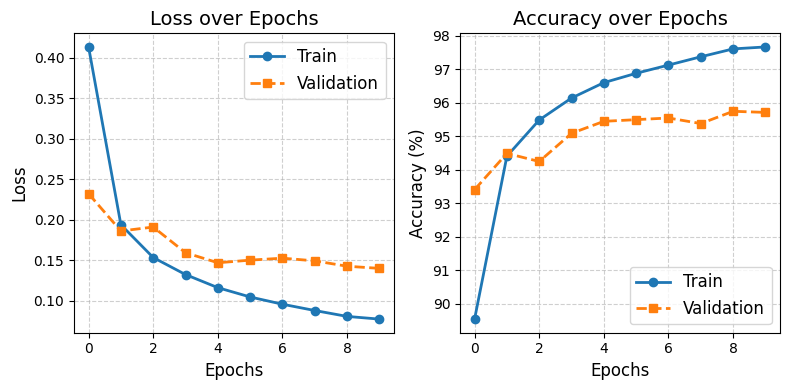

Test Accuracy: 95.87%
Test Loss: 0.1380
Training Time: 0:00:28.287791


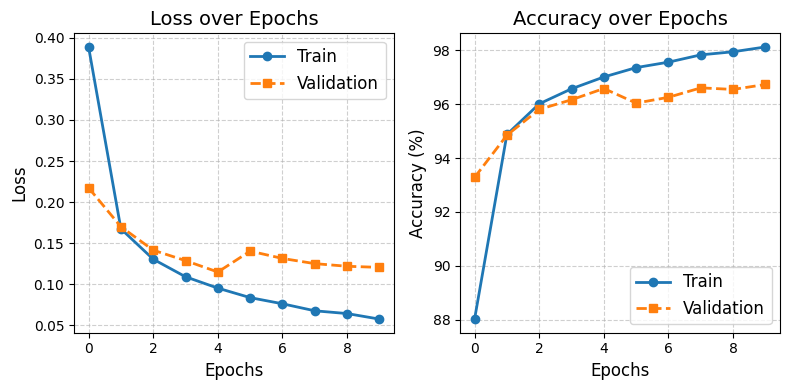

Test Accuracy: 96.93%
Test Loss: 0.1068
Training Time: 0:00:28.964888


,Model,Activation,Test Accuracy (%),Test Loss,Training Time (s)
0,Baseline MLP,Sigmoid,95.39,0.1662,28.06
1,Tanh MLP,Tanh,95.87,0.1380,28.29
2,ReLU MLP,ReLU,96.93,0.1068,28.96


In [18]:
# Tanh 모델 학습 결과 시각화
visualize_training_results(tanh_results)

# ReLU 모델 학습 결과 시각화
visualize_training_results(relu_results)

# 활성화 함수에 따른 성능 비교 (Sigmoid vs Tanh vs ReLU)
activation_performance_summary = {
    'Model': [baseline_results['model'], tanh_results['model'], relu_results['model']],
    'Activation': [baseline_results['activation'], tanh_results['activation'], relu_results['activation']],
    'Test Accuracy (%)': [f"{baseline_results['test_acc']:.2f}", f"{tanh_results['test_acc']:.2f}", f"{relu_results['test_acc']:.2f}"],
    'Test Loss': [f"{baseline_results['test_loss']:.4f}", f"{tanh_results['test_loss']:.4f}", f"{relu_results['test_loss']:.4f}"],
    'Training Time (s)': [f"{baseline_results['training_time']:.2f}", f"{tanh_results['training_time']:.2f}", f"{relu_results['training_time']:.2f}"]
}

# 결과 표 생성
activation_summary_df = pd.DataFrame(activation_performance_summary)
display(activation_summary_df)

## **실험 5: 옵티마이저 수정 모델 (Optimizer Variation)**

**모델 아키텍처**는 다음과 같습니다.

**가장 성능이 좋은 베이스-ReLU 함수 모델 사용:**
- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, ReLU 활성화 함수
- **은닉층 2**: 32 unit, ReLU 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 옵티마이저 수정 모델 정의

In [19]:
# 베이스 모델로 ReLU 모델을 사용
class AdamReLUMLP(nn.Module):
    def __init__(self):
        super(AdamReLUMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # ReLU 활성화 함수
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.relu(self.fc1(x))  # 첫 번째 은닉층 + ReLU 활성화 함수
        x = self.relu(self.fc2(x))  # 두 번째 은닉층 + ReLU 활성화 함수
        x = self.fc3(x)             # 출력층
        
        return x

# 모델 인스턴스 생성
adam_relu_model = AdamReLUMLP().to(device)
print("===== Adam 옵티마이저 + ReLU 활성화 함수 모델 =====")
print(adam_relu_model)

===== Adam 옵티마이저 + ReLU 활성화 함수 모델 =====
AdamReLUMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)


### 옵티마이저 수정 모델 학습

In [20]:
# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 정의
adam_learning_rate = 0.1 # 베이스라인과 같은 학습률 사용
adam_optimizer = optim.Adam(adam_relu_model.parameters(), lr=adam_learning_rate)

# 모델 학습 실행
num_epochs = 10
adam_model, adam_train_losses, adam_train_accs, adam_val_losses, adam_val_accs, adam_total_time = train_model(
    adam_relu_model, train_loader, val_loader, criterion, adam_optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
adam_test_loss, adam_test_acc = test_model(adam_relu_model, test_loader, criterion, device)

# 실험 결과 저장
adam_results = {
    'model': 'Adam ReLU MLP',
    'hidden_layers': '2 layers, 32 units each',
    'activation': 'ReLU',
    'optimizer': 'Adam',
    'learning_rate': adam_learning_rate,
    'train_losses': adam_train_losses,
    'train_accs': adam_train_accs,
    'val_losses': adam_val_losses,
    'val_accs': adam_val_accs,
    'test_loss': adam_test_loss,
    'test_acc': adam_test_acc,
    'training_time': adam_total_time
}

print("-" * 50)
print("Adam 옵티마이저 + ReLU 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 1.9072, Accuracy: 27.97%
Valid - Loss: 1.7288, Accuracy: 29.07%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 1.9773, Accuracy: 20.12%
Valid - Loss: 1.9562, Accuracy: 18.72%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 1.9798, Accuracy: 18.86%
Valid - Loss: 1.9664, Accuracy: 19.48%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 2.0224, Accuracy: 18.06%
Valid - Loss: 2.1106, Accuracy: 18.03%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 1.9988, Accuracy: 18.45%
Valid - Loss: 1.9992, Accuracy: 18.07%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 1.9493, Accuracy: 18.69%
Valid - Loss: 1.9161, Accuracy: 19.32%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 1.9255, Accuracy: 19.16%
Valid - Loss: 1.9157, Accuracy: 19.0

### 모델 학습 결과 시각화 및 비교

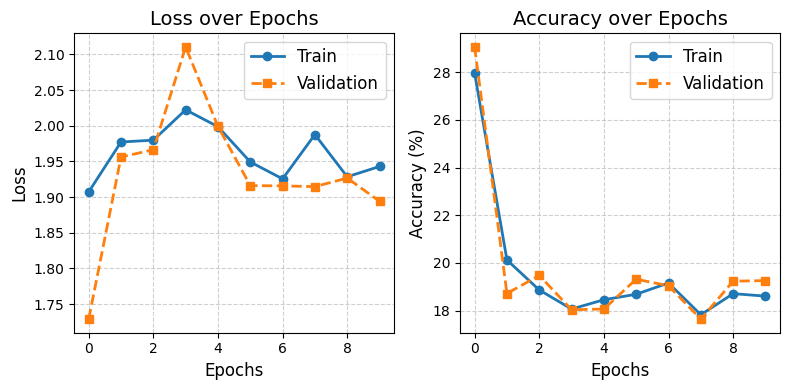

Test Accuracy: 19.35%
Test Loss: 1.8900
Training Time: 0:00:29.519686


,Model,Optimizer,Learning Rate,Activation,Test Accuracy (%),Test Loss,Training Time (s)
0,ReLU MLP,SGD,0.1000,ReLU,96.93,0.1068,28.96
1,Adam ReLU MLP,Adam,0.1000,ReLU,19.35,1.8900,29.52


In [21]:
# Adam 모델 학습 결과 시각화
visualize_training_results(adam_results)

# 옵티마이저에 따른 성능 비교 (SGD vs Adam - 둘 다 ReLU 사용)
optimizer_performance_summary = {
    'Model': [relu_results['model'], adam_results['model']],
    'Optimizer': [relu_results['optimizer'], adam_results['optimizer']],
    'Learning Rate': [f"{relu_results['learning_rate']:.4f}", f"{adam_results['learning_rate']:.4f}"],
    'Activation': [relu_results['activation'], adam_results['activation']],
    'Test Accuracy (%)': [f"{relu_results['test_acc']:.2f}", f"{adam_results['test_acc']:.2f}"],
    'Test Loss': [f"{relu_results['test_loss']:.4f}", f"{adam_results['test_loss']:.4f}"],
    'Training Time (s)': [f"{relu_results['training_time']:.2f}", f"{adam_results['training_time']:.2f}"]
}

# 결과 표 생성
optimizer_summary_df = pd.DataFrame(optimizer_performance_summary)
display(optimizer_summary_df)

## **실험 6. 학습률 조정 모델 (Learning rate Variation)**

**모델 아키텍처**는 다음과 같습니다.

**가장 성능이 좋은 베이스-ReLU-SGD 함수 모델 사용:**
- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, ReLU 활성화 함수
- **은닉층 2**: 32 unit, ReLU 활성화 함수
- **출력층**: 10 unit (0-9 class)

### 학습률 조정 모델 정의

In [22]:
class LearningRateMLP(nn.Module):
    def __init__(self):
        super(LearningRateMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # ReLU 활성화 함수
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.relu(self.fc1(x))  # 첫 번째 은닉층 + ReLU 활성화 함수
        x = self.relu(self.fc2(x))  # 두 번째 은닉층 + ReLU 활성화 함수
        x = self.fc3(x)             # 출력층
        
        return x

### 학습률 조정 모델 학습

In [23]:
# 다양한 학습률로 모델 학습 및 평가
learning_rates = [1.0, 0.1, 0.01]
lr_results = {}

# 각 학습률에 대해 실험 수행
for lr in learning_rates:
    print(f"\n===== 학습률 {lr} 실험 =====")
    
    # 모델 초기화
    lr_model = LearningRateMLP().to(device)
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    lr_optimizer = optim.SGD(lr_model.parameters(), lr=lr)
    
    # 모델 학습
    num_epochs = 10
    lr_model, lr_train_losses, lr_train_accs, lr_val_losses, lr_val_accs, lr_total_time = train_model(
        lr_model, train_loader, val_loader, criterion, lr_optimizer, device, num_epochs)
    
    # 테스트 세트에 대한 최종 평가
    lr_test_loss, lr_test_acc = test_model(lr_model, test_loader, criterion, device)
    
    # 실험 결과 저장
    lr_results[lr] = {
        'model': f'ReLU MLP (LR={lr})',
        'hidden_layers': '2 layers, 32 units each',
        'activation': 'ReLU',
        'optimizer': 'SGD',
        'learning_rate': lr,
        'train_losses': lr_train_losses,
        'train_accs': lr_train_accs,
        'val_losses': lr_val_losses,
        'val_accs': lr_val_accs,
        'test_loss': lr_test_loss,
        'test_acc': lr_test_acc,
        'training_time': lr_total_time
    }
    
    print(f"학습률 {lr} 실험 완료!")


===== 학습률 1.0 실험 =====
학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 2.8581, Accuracy: 13.64%
Valid - Loss: 2.3071, Accuracy: 9.99%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 2.3093, Accuracy: 10.56%
Valid - Loss: 2.3044, Accuracy: 11.15%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 2.2969, Accuracy: 10.88%
Valid - Loss: 2.3039, Accuracy: 9.99%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 2.3047, Accuracy: 10.44%
Valid - Loss: 2.3081, Accuracy: 11.15%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 2.3049, Accuracy: 10.65%
Valid - Loss: 2.3041, Accuracy: 9.80%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 2.3045, Accuracy: 10.50%
Valid - Loss: 2.3092, Accuracy: 11.16%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 2.3042, Accuracy: 10.73%
Valid - Loss: 2

### 모델 학습 결과 시각화 및 비교


===== 학습률 1.0 결과 =====


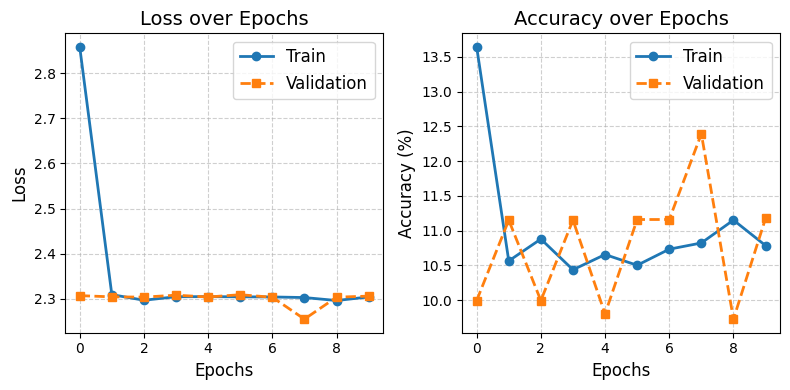

Test Accuracy: 11.37%
Test Loss: 2.3048
Training Time: 0:00:28.165748

===== 학습률 0.1 결과 =====


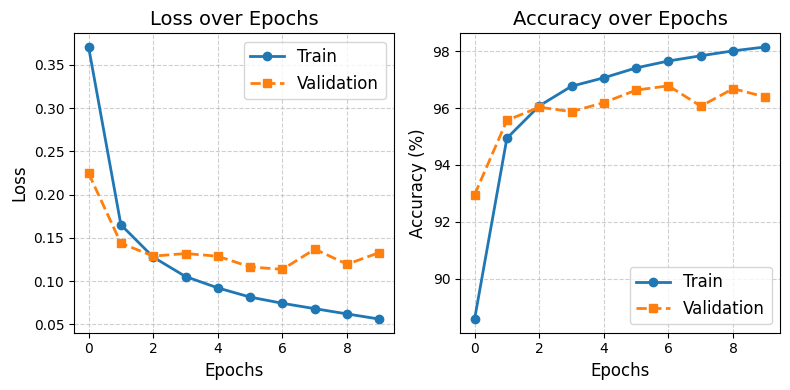

Test Accuracy: 96.45%
Test Loss: 0.1264
Training Time: 0:00:28.679291

===== 학습률 0.01 결과 =====


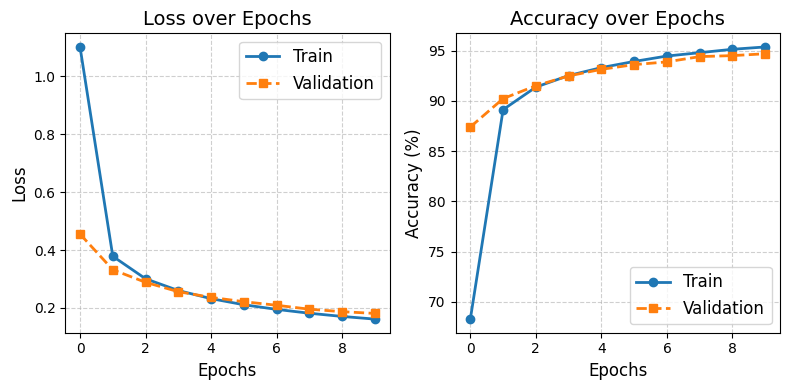

Test Accuracy: 95.30%
Test Loss: 0.1671
Training Time: 0:00:29.409594

다양한 학습률 모델 결과


,Model,Learning Rate,Activation,Test Accuracy (%),Test Loss,Training Time (s)
0,ReLU MLP (LR=1.0),1.00,ReLU,11.37,2.3048,28.17
1,ReLU MLP (LR=0.1),0.10,ReLU,96.45,0.1264,28.68
2,ReLU MLP (LR=0.01),0.01,ReLU,95.30,0.1671,29.41



학습률 종합 평가


,Learning Rate,Training Stability,Overfitting Risk,Efficiency Score
0,1.00,불안정 (발산 가능성),중간,⭐
1,0.10,안정적,중간,⭐⭐⭐
2,0.01,매우 안정적,낮음,⭐⭐⭐⭐


In [32]:
# 학습률 실험 결과 시각화 및 비교
for lr in learning_rates:
    print(f"\n===== 학습률 {lr} 결과 =====")
    visualize_training_results(lr_results[lr])

# 성능 비교 표 생성
lr_performance_summary = {
    'Model': [lr_results[lr]['model'] for lr in learning_rates],
    'Learning Rate': [lr for lr in learning_rates],
    'Activation': ['ReLU' for _ in learning_rates],
    'Test Accuracy (%)': [f"{lr_results[lr]['test_acc']:.2f}" for lr in learning_rates],
    'Test Loss': [f"{lr_results[lr]['test_loss']:.4f}" for lr in learning_rates],
    'Training Time (s)': [f"{lr_results[lr]['training_time']:.2f}" for lr in learning_rates]
}

print("\n다양한 학습률 모델 결과")
# 결과 표 생성
lr_summary_df = pd.DataFrame(lr_performance_summary)
display(lr_summary_df)

# 학습률 실험에 대한 종합적 평가 표 생성
comprehensive_summary = {
    'Learning Rate': learning_rates,
    'Training Stability': ['불안정 (발산 가능성)' if lr == 1.0 else '안정적' if lr == 0.1 else '매우 안정적' for lr in learning_rates],
    'Overfitting Risk': ['중간' if lr == 1.0 else '중간' if lr == 0.1 else '낮음' for lr in learning_rates],
    'Efficiency Score': [
        '⭐' if lr == 1.0 else 
        '⭐⭐⭐' if lr == 0.1 else 
        '⭐⭐⭐⭐'
        for lr in learning_rates
    ]
}

print("\n학습률 종합 평가")
# 결과 표 생성 및 정렬
comprehensive_df = pd.DataFrame(comprehensive_summary)
display(comprehensive_df)